# Emulation comparison 


#### This file is an example of the research I am currently doing, presented at a conference.To see more of the project, see: https://github.com/YusufBhatti/PPE_Project

## **Quantifying Aerosol Radiative Forcing Uncertainty within an Earth System Model using Perturbed Parameter Ensembles**

### Authors:
#### Yusuf Bhatti, Duncan Watson-Parris, Hailing Jia, David Neubauer, Ulrike Lohman, Ulas Im, Nick Schutgens, Athanasios Tsikerdekis, Ardit Arifi, Otto Hasekamp

--- 

Aerosols affect climate through aerosol-radiation interactions (ARI) and aerosol-cloud interactions (ACI), resulting in a negative radiative forcing (cooling) masking part of the warming by Greenhouse gases. However, climate models face significant uncertainties in quantifying the aerosol cooling effect due to uncertainties in aerosol processes and properties, posing challenges for accurate long-term climate predictions and projections. Our study aims to reduce these uncertainties using a perturbed parameter ensemble (PPE) using the ECHAM6-HAM2.3 model. We perturb 25 aerosol parameters for both preindustrial and present-day atmospheres and will analyze the resulting aerosol forcing uncertainties and their underlying causes. Both convolutional neural network and Gaussian processes machine learning techniques are used to emulate the ensemble. This work lays the foundation for future work where the PPE will be used in combination with novel satellite observations by the NASA PACE and ESA Earthcare mission to reduce climate model uncertainty.

In [4]:
## Preamble code added from subdirectories to present the machine learning process involved in this script ##
import numpy as np
import tensorflow as tf

from wrappers import wrap_data
from model_adaptor import ModelAdaptor
from data_processors import Recast, Whiten, Reshape as Reshaper, Flatten
from wrappers import *
from model_adaptor import *
from emulator import *
from abc_sampler import *
from sampler import *
from utils import *
from wrappers import wrap_data
from data_processors import Recast, Whiten, Reshape as Reshaper, Flatten
from emulator import Emulator
import pkg_resources

def cnn_model(training_params, training_data, data_processors=None,
              filters=12, learning_rate=1e-3, decay=0.01,
              kernel_size=(3, 5), loss='mean_squared_error',
              activation='tanh', optimizer='RMSprop', name='', gpu=0):
    """
    Create a simple two layer Convolutional Neural Network Emulator using Keras.

    Note that X should include both the train and validation data

    Parameters
    ----------
    training_params: pd.DataFrame
        The training parameters
    training_data: xarray.DataArray or iris.cube.Cube or array_like
        The training data - the leading dimension should represent training samples
    data_processors: list of esem.data_processors.DataProcessor
        A list of `DataProcessor` to apply to the data transparently before training. Model output will be
        un-transformed before being returned from the Emulator.
    filters: int
        The dimensionality of the first convolutional layer output space
    learning_rate: float
        The learning rate to use with the chosen optimizer
    decay: float
        Any decay to appAOD_PI=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').TAU_2D_550nm
ly to the learning rate
    kernel_size: tuple of int
        The convolutional kernel size
    loss: str
        The loss function to train against (see https://keras.io/api/losses/)
    activation: str
        The activation function to use in the final CNN layer (see https://keras.io/api/layers/activations/)
    optimizer: {'RMSprop', 'Adam'}
        The optimizer to train the model with
    name: str
        An optional name for the emulator
    gpu: int
        The GPU to use (only applicable for multi-GPU) machines


    Returns
    -------
    Emulator
        An esem emulator object which can be trained and sampled from


    Notes
    -----
    The Keras model is compiled but not trained until `train` is called on the returned `Emulator` object.

    """
    from model_adaptor import KerasModel
    from tensorflow.keras.layers import Dense, Input, Reshape, Conv2DTranspose
    from tensorflow.keras.models import Model
    from tensorflow.keras.optimizers import Adam, RMSprop
    from tensorflow.keras.optimizers.schedules import ExponentialDecay
    from tensorflow.keras.backend import floatx
    import numpy as np

    if optimizer == 'RMSprop':
        optimizer = RMSprop
    elif optimizer == 'Adam':
        optimizer = Adam
    else:
        raise ValueError("Invalid optimizer specified: {}".format(optimizer))

    # Add whitening and reshaping processors
    data_processors = data_processors if data_processors is not None else []
    data_processors.extend([Recast(floatx()), Whiten(), Reshaper()])
    data = wrap_data(training_data, data_processors=data_processors)

    # build a simple decoder model
    # NOTE that this assumes the data doesn't get reshaped by the data processors...
    latent_inputs = Input((training_params.shape[1],))
    intermediate_shape = data.process_wrapper.data.shape[1:-1] + (filters,)
    x = Dense(np.product(intermediate_shape), activation='relu')(latent_inputs)
    x = Reshape(intermediate_shape)(x)

    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=1,
                        padding='same', data_format='channels_last')(x)

    outputs = Conv2DTranspose(filters=data.process_wrapper.data.shape[-1],
                              kernel_size=kernel_size,
                              activation=activation,
                              strides=1,
                              padding='same', data_format='channels_last')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')

    lr_schedule = ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=10000,
        decay_rate=decay)

    decoder.compile(optimizer=optimizer(learning_rate=lr_schedule), loss=loss)

    model = KerasModel(decoder)

    return Emulator(model, training_params, data, name=name, gpu=gpu)

def gp_model(training_params, training_data, data_processors=None,
             kernel=None, kernel_op='add', active_dims=None, noise_variance=1.,
             name='', gpu=0, **kwargs):
    """
    Create a Gaussian process (GP) based emulator with provided `training_params` (X) and `training_data` (Y) which
    assumes independent inputs (and outputs).

    The `kernel` is a key parameter in GP emulation and care should be taken in choosing it.

    Parameters
    ----------
    training_params: DataFrame
        The training parameters
    training_data: xarray.DataArray or iris.Cube or array_like
        The training data - the leading dimension should represent training samples
    data_processors: list of esem.data_processors.DataProcessor
        A list of 'DataProcessor` to apply to the data transparently before training. Model output will be
        un-transformed before being returned from the Emulator.
    kernel: gpflow.kernels.Kernel or list of str or None
        The GP kernel to use.  A GPFlow kernel can be specified directly, or a list of kernel names can be provided
        which will be initialised using the default values (of the correct shape) and combined using `kernel_op`.
        Alternatively no kernel can be specified and a default will be used.
    kernel_op : {'add', 'mul'}
        The operation to perform in order to combine the specified `kernel`s. Only used if `kernel` is a list of strings.
    noise_variance: float
        The noise variance to initialise the GP regression model
    active_dims: list of int or slice or None
        The dimensions to train the GP over (by default all of the dimensions are used)
    name: str
        An optional name for the emulator
    gpu: int
        The GPU to use (only applicable for multi-GPU) machines
    kwargs: dict
        Dict of optional keyword arguments for `gpflow.models.GPR`, e.g., `mean_function`

    Returns
    -------
    Emulator
        An esem emulator object which can be trained and sampled from

    """

    from model_adaptor import GPFlowModel
    import tensorflow as tf
    import gpflow
    from gpflow.config import default_float

    n_params = training_params.shape[1]

    data_processors = data_processors if data_processors is not None else []
    data_processors.extend([Recast(default_float()), Flatten()])
    wrapped_data = wrap_data(training_data, data_processors=data_processors)

    if kernel is None:
        print("WARNING: Using default kernel - be sure you understand the assumptions this implies. "
              "Consult e.g.  http://www.cs.toronto.edu/~duvenaud/cookbook/ for an excellent description of "
              "different kernel choices.")
        kernel = ['RBF', 'Linear', 'Polynomial', 'Bias']  # This gets turned in to a real kernel next
    if isinstance(kernel, list):
        kernel = _get_gpflow_kernel(kernel, n_params, active_dims=active_dims, operator=kernel_op)
    elif not isinstance(kernel, gpflow.kernels.Kernel):
        raise ValueError("Invalid kernel specified: {}".format(kernel))
    # Else, use the user specified kernel

    model = GPFlowModel(gpflow.models.GPR(data=(training_params.values, wrapped_data.data),
                                          kernel=kernel,
                                          noise_variance=tf.constant(noise_variance,
                                          dtype=wrapped_data.dtype), **kwargs))

    return Emulator(model, training_params, wrapped_data, name=name, gpu=gpu)


In [5]:
import os
import numpy as np
## Ignore my broken HDF5 install|...
os.putenv("HDF5_DISABLE_VERSION_CHECK", '1')

def get_memory_usage():
    process = psutil.Process()
    mem_info = process.memory_info()
    return mem_info.rss/1000000000  # Return resident set size in bytes


In [6]:
import iris
from esem import *
import psutil
import seaborn
import iris.quickplot as qplt
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import xarray as xr
from my_personal_functions import *
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import gc

print(f"Memory usage: {get_memory_usage()} GB")



Memory usage: 0.56119296 GB


## Read in the parameters and data

In [7]:
lats=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').lat
lons=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').lon

#ppe_aod = xr.open_dataset('/home/ybhatti/prjs1076/Emulator/Tester/AOD_Ensembles_Tester.nc').TAU_2D_550nm[:]#[:-1]#.mean('time')[:-1]
AOD_PI=xr.open_dataset('/home/ybhatti/prjs1076/Processed_Data/PI/Processed/AOD_PPE.nc').TAU_2D_550nm


In [8]:
ppe_params = pd.read_csv('~/yusufb/Branches/PPE_Scripts/parameter_values_data/PPE_values.csv')[:]

valid_ensembles = AOD_PI['ensemble'].values  # Get ensemble values from AOD_PI
valid_ensembles = valid_ensembles[valid_ensembles != 0]  # Exclude control ensemble (0)

ppe_params.set_index(ppe_params.columns[0], inplace=True)
valid_params = ppe_params[ppe_params.index.isin([f'PPE_ENS_{ens}' for ens in valid_ensembles])]

# Create the new row with all columns set to 1, and update specific values
new_row = {col: 1 for col in valid_params.columns}
new_row.update({
    'V_SCALE_BC_RAD_NI': 0.71,
    'V_SCALE_DU_RAD_NI': 0.001,
    'V_SCALE_PH_PERT': 2.5e-06,
    'V_SCALE_CDNC_MIN': 40,
    'V_SCALE_KAPPA_SO4': 0.6

})

# Create a DataFrame for the new row
new_row_df = pd.DataFrame([new_row], index=['PPE_Control'])

# Concatenate the new row DataFrame with the original DataFrame
ppe_params = pd.concat([new_row_df, valid_params])

ppe_paramater = np.log(ppe_params)
ppe_para = ppe_paramater.apply(normalize, axis=0)


In [10]:
print(ppe_para)

             V_SCALE_BC_RAD_NI  V_SCALE_DU_RAD_NI  V_SCALE_DRYDEP_ACC  \
PPE_Control           0.842601           0.592657            0.474397   
PPE_ENS_1             0.698389           0.795857            0.923506   
PPE_ENS_2             0.984170           0.915565            0.856420   
PPE_ENS_3             0.756427           0.885145            0.740432   
PPE_ENS_4             0.306361           0.710899            0.983062   
...                        ...                ...                 ...   
PPE_ENS_196           0.035563           0.947056            0.931903   
PPE_ENS_197           0.597180           0.954281            0.940708   
PPE_ENS_198           0.551966           0.860027            0.787054   
PPE_ENS_199           0.904980           0.427060            0.630631   
PPE_ENS_200           0.800309           0.657565            0.927381   

             V_SCALE_DRYDEP_AIT  V_SCALE_DRYDEP_COA  V_SCALE_EMI_BB  \
PPE_Control            0.695843            0.529731 

# Test / Train ration (30% train)

In [14]:
ppe_aod=AOD_PI[:].mean('time')
n_test=60
X_test, X_train = ppe_para[:n_test], ppe_para[n_test:]
Y_test, Y_train = ppe_aod[:n_test], ppe_aod[n_test:]
gc.collect()

0

## Setup and train the models

In [15]:
nn_model = cnn_model(X_train, Y_train)


/scratch-local/ybhatti.8059925/ipykernel_990461/3052461215.py:1: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  nn_model = cnn_model(X_train, Y_train)
2024-10-03 13:01:41.794936: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
/home/ybhatti/yusufb/miniconda3/envs/ESM/lib/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [16]:
nn_model.model.model.summary()


Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 25)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 221184)         │     5,750,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 96, 192, 12)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 96, 192, 12)    │         2,172 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 96, 192, 1)     │           181 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,753,137 (21.95 MB)

 Trainable params: 5,753,137 (21.95 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
%%time
nn_model.train()
print(f"Memory usage: {get_memory_usage()} GB")


Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.9038 - val_loss: 0.9774
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9806 - val_loss: 0.9790
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0191 - val_loss: 0.9798
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.0185 - val_loss: 0.9845
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.1455 - val_loss: 0.9857
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 1.0832 - val_loss: 0.9792
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9955 - val_loss: 0.9740
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.9361 - val_loss: 0.9591
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8056 - val_loss: 0.9659
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8844 - val_loss: 0.9016
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7939 - val_loss: 0.8418
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

In [18]:
## Prediction for CNN model
nn_prediction, _ = nn_model.predict(X_test.values)

In [ ]:
    # Plot distributions 
    plt.figure(figsize=(12, 6))
    plt.hist(Y_test.data.flatten(), bins=1000, alpha=0.5, label='Actual Values')
    plt.hist(nn_prediction.data.flatten(), bins=1000, alpha=0.5, label='Predicted Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Actual vs. Predicted Values')
    plt.xlim(0,.3)
    plt.legend()
    plt.grid(True)
    plt.show()


In [20]:
gp_model_ = gp_model(X_train, Y_train, kernel=['Bias', 'Linear'])
gp_model_.train()
print(f"Memory usage: {get_memory_usage()} GB")


Memory usage: 1.247379456 GB


In [21]:
gp_prediction, _ = gp_model_.predict(X_test.values)

In [ ]:
# Plot distributions 
plt.figure(figsize=(12, 6))
plt.hist(Y_test.data.flatten(), bins=1000, alpha=0.5, label='Actual Values')
plt.hist(gp_prediction.data.flatten(), bins=1000, alpha=0.5, label='Predicted Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Actual vs. Predicted Values')
plt.xlim(0,.3)
plt.legend()
plt.grid(True)
plt.show()


# Model Validation

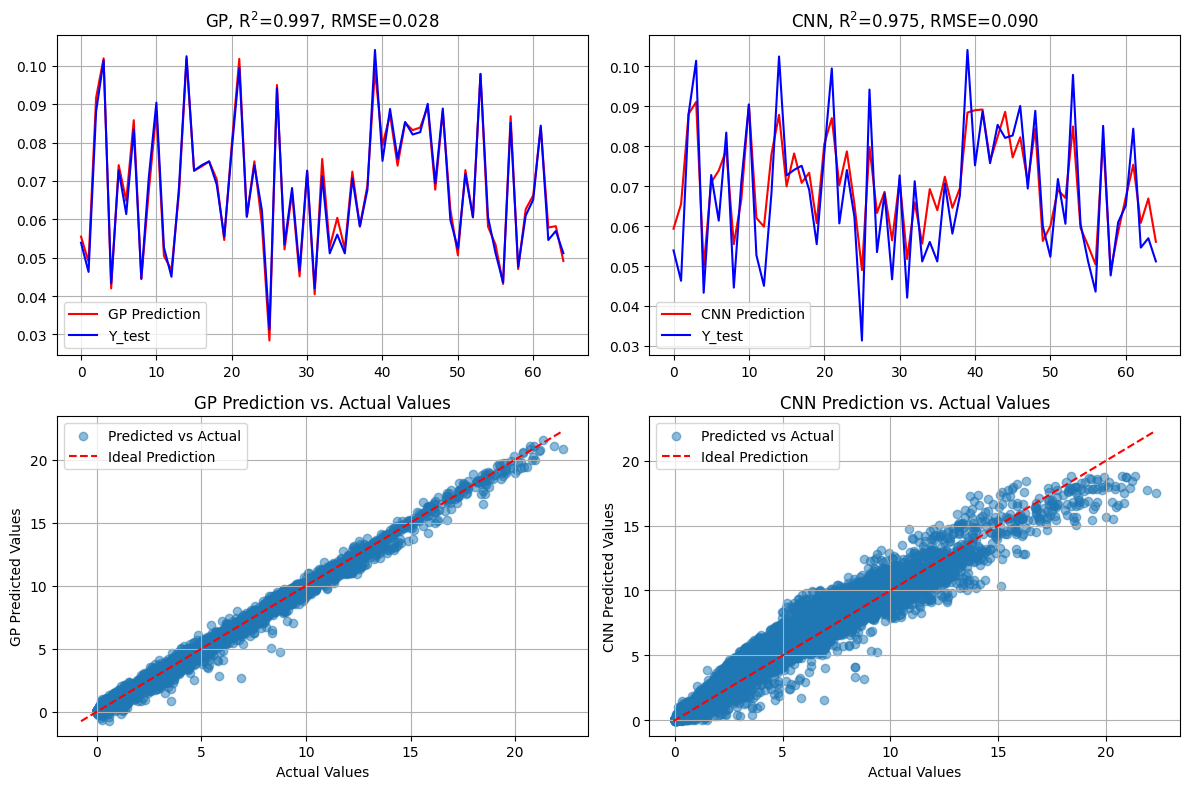

In [140]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
from math import sqrt
from sklearn.metrics import mean_squared_error

# Line plots
for ax, pred, title in zip(axs[0], [gp_prediction, nn_prediction], ['GP', 'CNN']):
    rmse_lines = sqrt(mean_squared_error(pred.data.flatten(),Y_test.data.flatten()))
    bias_lines = areaweight(pred,lats).mean() - areaweight(Y_test,lats).mean()
    r2_lines = np.corrcoef(pred.data.flatten(), Y_test.data.flatten())[1][0]**2

    ax.plot(pred.mean(['lat','lon']), color='red', label=f'{title} Prediction')
    ax.plot(Y_test.mean(['lat','lon']), color='blue', label='Y_test')
    ax.set_title(f"{title}, R$^{2}$={r2_lines:.3f}, RMSE={rmse_lines:.3f}")
    ax.legend()
    ax.grid(True)

# Scatter plots
for ax, pred, title in zip(axs[1], [gp_prediction, nn_prediction], ['GP', 'CNN']):
    min_val, max_val = min(np.min(Y_test), np.min(pred)), max(np.max(Y_test), np.max(pred))
    ax.scatter(Y_test, pred, alpha=0.5, label='Predicted vs Actual')
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction')
    ax.set_xlabel('Actual Values')
    ax.set_ylabel(f'{title} Predicted Values')
    ax.set_title(f'{title} Prediction vs. Actual Values')
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


Proportion of 'Bad' estimates : 1.24%


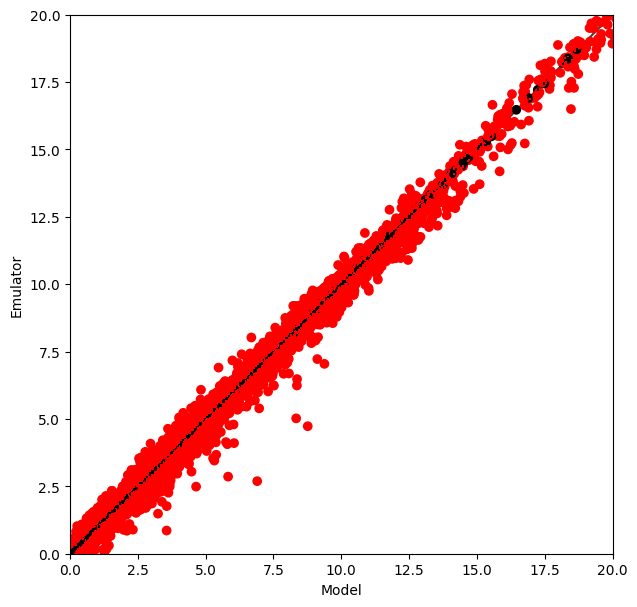

In [141]:
from esem.utils import validation_plot, plot_parameter_space, get_random_params, ensemble_collocate
validation_plot(Y_test.data.flatten(), gp_prediction.data.flatten(), _.data.flatten(),
               minx=0, maxx=20, miny=0., maxy=20)



# Preliminary Analysis

In [23]:
# Function to create map plots
def plot_map(ax, data, xa, ya, cmap, levels=None, title=None):
    map_ax = Basemap(llcrnrlon=0., llcrnrlat=-85, urcrnrlon=360., urcrnrlat=85, projection='cyl', resolution='c', ax=ax)
    x, y = map_ax(xa, ya)
    map_ax.drawcoastlines()
    map_ax.drawcountries()
    map_ax.drawmeridians(np.arange(0., 360, 60.), labels=[0, 0, 0, 1], fontsize=8)
    map_ax.drawparallels(np.arange(-90., 90, 30.), labels=[1, 0, 0, 0], fontsize=8)
    if levels is not None:
        cs = map_ax.contourf(x, y, data, levels, extend='both', cmap=cmap)
    else:
        cs = map_ax.contourf(x, y, data, extend='both', cmap=cmap)
    if title:
        ax.set_title(title, fontsize=14)
    return cs



In [24]:
#new_samples = pd.DataFrame(0, index=range(n), columns=ppe_param.columns)
# Extract the PPE_Control row as a Series

def PPE_Uncertainty(n,VARIABLE,ppe_control_values):    
        #data = new_samples
    # Create a new DataFrame with `n` rows, where each row is filled with the `PPE_Control` values
    new_samples = pd.DataFrame([ppe_control_values] * n, index=range(n))

    new_samples[VARIABLE] = np.random.uniform(0, 1, n)  # V_SCALE_EMI_SS with values between 0.5 and 2.5
    
    m, sd = gp_model_.batch_stats(new_samples, batch_size=n)
    mnn, sdnn = nn_model.batch_stats(new_samples, batch_size=n)
    print(f"Memory usage: {get_memory_usage()} GB")
    
    print(f"Memory usage: {get_memory_usage()} GB")
    gc.collect()
    return m ,sd, mnn, sdnn

In [27]:
ppe_control_values = ppe_para.loc['PPE_Control']
Variable='V_SCALE_EMI_SSA'
#mss, sdss, mnnss, sdnnss = PPE_Uncertainty(1000,Variable,ppe_control_values)


  0%|          | 0/1000 [00:00<?, ?sample/s]

  0%|          | 0/1000 [00:00<?, ?sample/s]

<tqdm.auto.tqdm object at 0x14864ff3c810>Memory usage: 3.670233088 GB
Memory usage: 3.670233088 GB


/scratch-local/ybhatti.8059925/ipykernel_990461/3721363237.py:23: RuntimeWarning: divide by zero encountered in divide
  rel_per_diff=(((sd.data / m.data) / (sdnn.data / mnn.data))-1) * 100


Text(0.5, 0.76, 'V_SCALE_EMI_SSA')

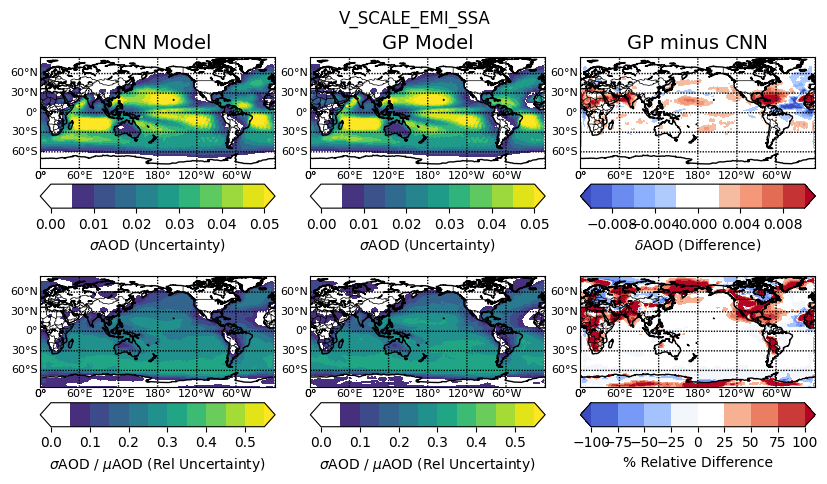

In [30]:
# Plot comparing the two machine learning approaches #


fig, axs = plt.subplots(2, 3, figsize=(10, 8), gridspec_kw={'height_ratios': [1, 1], 'hspace': -0.45, 'wspace': 0.15})
clevs = [np.arange(0, 0.05 + 0.005, 0.005),
         np.arange(0, 0.05 + 0.005, 0.005),
         np.arange(-0.01, 0.01 + 0.002, 0.002)]

rel_clevs = [np.arange(0, 0.6, 0.05),
             np.arange(0, 0.6, 0.05),
             np.arange(-100,100 + 25, 25)]
coolwarm_dataset = plt.cm.viridis(np.linspace(0, 1, 128))
coolwarm_dataset[0:16, :] = 1.0  # Set center values as white
coolwarm_whites = LinearSegmentedColormap.from_list('coolwarm_white', coolwarm_dataset)
coolwarm_dataset_middle = plt.cm.coolwarm(np.linspace(0, 1, 128))
coolwarm_dataset_middle[56:80, :] = 1.0  # Set center values as white
coolwarm_whites_middle = LinearSegmentedColormap.from_list('coolwarm', coolwarm_dataset_middle)


# ppe_control_values = ppe_para.loc['PPE_Control']
m, sd, mnn, sdnn = PPE_Uncertainty(1000,Variable,ppe_control_values)

rel_per_diff=(((sd.data / m.data) / (sdnn.data / mnn.data))-1) * 100
xa, ya = np.meshgrid(lons, lats)
data_top = [sdnn.data, sd.data, sd.data - sdnn.data]
data_bot = [sdnn.data / mnn.data, sd.data / m.data, rel_per_diff ]
titles = ['CNN Model', 'GP Model','GP minus CNN']


# Plot absolute uncertainties (std) in the top row
cs1 = [plot_map(axs[0, i], data_top[i], xa, ya, coolwarm_whites,clevs[i], titles[i]) for i in range(2)]
cs1 += [plot_map(axs[0, i], data_top[i], xa, ya, coolwarm_whites_middle,clevs[i], titles[i]) for i in range(2,3)]

# Plot relative uncertainties (std/mean) in the bottom row
cs2 = [plot_map(axs[1, i], data_bot[i], xa, ya, coolwarm_whites,rel_clevs[i]) for i in range(2)]
cs2 += [plot_map(axs[1, i], data_bot[i], xa, ya, coolwarm_whites_middle,rel_clevs[i]) for i in range(2,3)]

# Plot the DIFFERENCES between CNN and GP

labels= [f'$\sigma$AOD (Uncertainty)', f'$\sigma$AOD (Uncertainty)', f'$\delta$AOD (Difference)']
rel_labels=[f'$\sigma$AOD / $\mu$AOD (Rel Uncertainty)',f'$\sigma$AOD / $\mu$AOD (Rel Uncertainty)', '% Relative Difference']
for i in range(3):
    # Color bar for absolute uncertainties (std)
    cax1 = fig.add_axes([axs[0, i].get_position().x0, axs[0, i].get_position().y0 - 0.05, axs[0, i].get_position().width, 0.03])
    fig.colorbar(cs1[i], cax=cax1, extend='both', orientation='horizontal').set_label(labels[i], fontsize=10)

    # Color bar for relative uncertainties (std/mean)
    cax2 = fig.add_axes([axs[1, i].get_position().x0, axs[1, i].get_position().y0 - 0.05, axs[1, i].get_position().width, 0.03])
    fig.colorbar(cs2[i], cax=cax2, extend='both', orientation='horizontal').set_label(rel_labels[i], fontsize=10)

# # Adding colorbars at the bottom
# cax1 = fig.add_axes([0.11, 0.1, 0.38, 0.02])
# fig.colorbar(cs1[0], cax=cax1, extend='both', orientation='horizontal').set_label(f'$\sigma$AOD', fontsize=12)
plt.suptitle(f'{Variable}', y=0.76)  # Adjust y to position the title lower
# fig.colorbar(cs2[1], cax=cax2, extend='both', orientation='horizontal').set_label(f'$\sigma$AOD / $\mu$AOD', fontsize=12)
